In [7]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    
    img_gray_lp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list ,img_binary_lp
import re

def filterStr(s): 
    pattern = re.compile("[A-Z0-9]+")
    return pattern.findall(s)

In [8]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :
    
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            #plt.imshow(ii, cmap='gray')  if u want to show the conteur in the plate for each caracter 

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['073300', '115', '16'] 0.6906205779599709


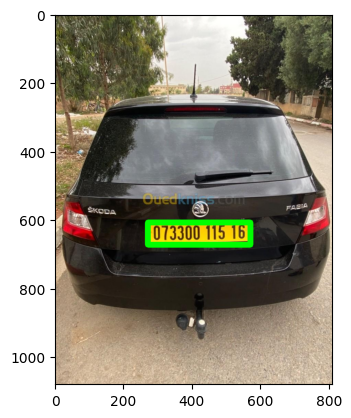

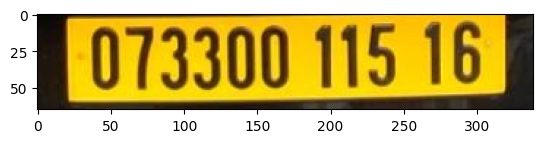

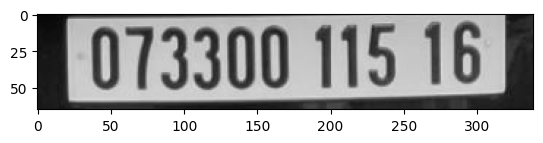

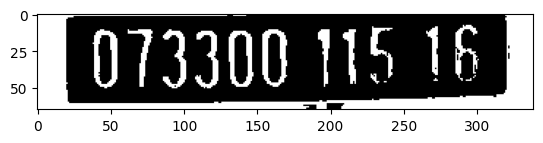

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


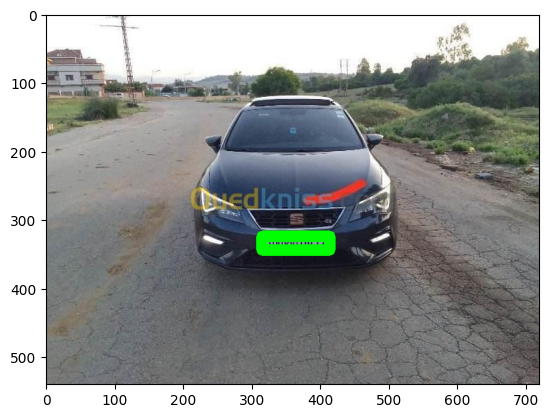

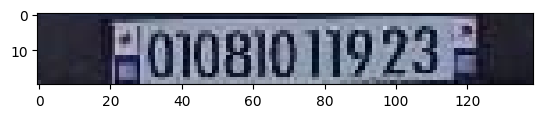

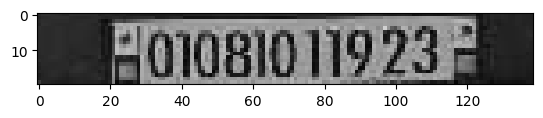

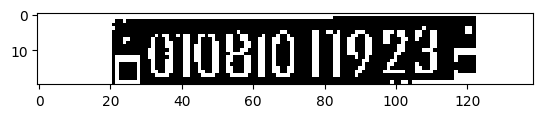

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['004143198', '13'] 0.9372886429170714


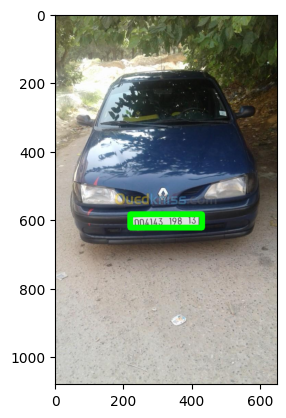

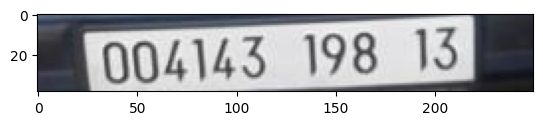

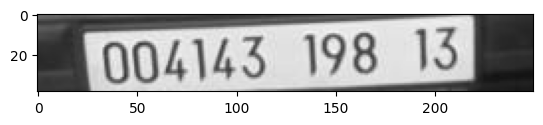

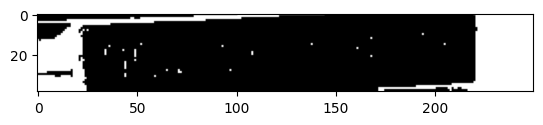

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['26755'] 0.878634204164033
['112', '26'] 0.6048820767075809


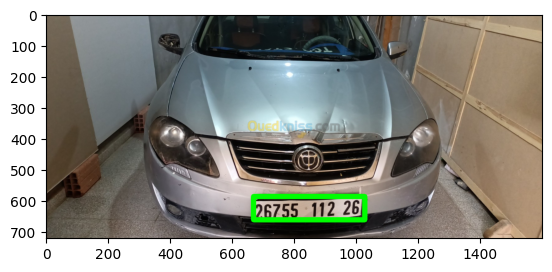

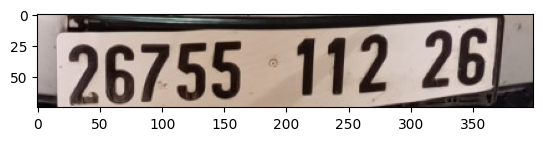

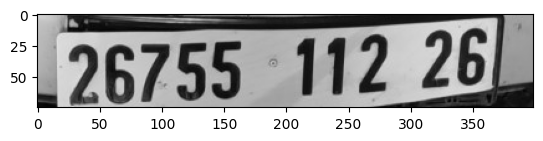

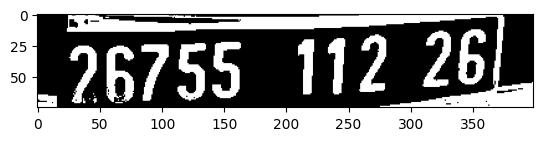

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['35336', '112', '42'] 0.49177648858662076


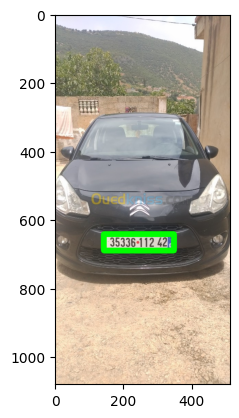

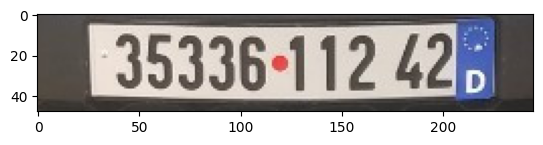

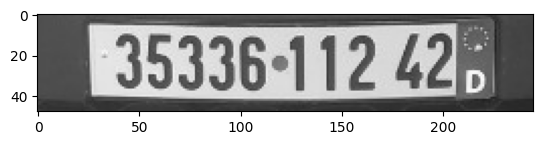

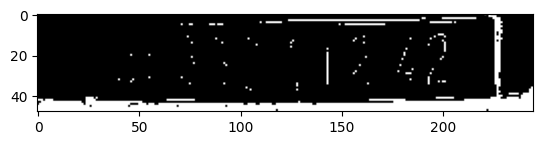

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['083609', '114', '16'] 0.8831628423245588


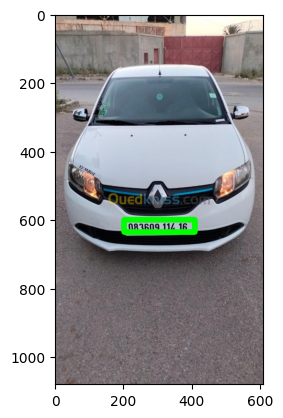

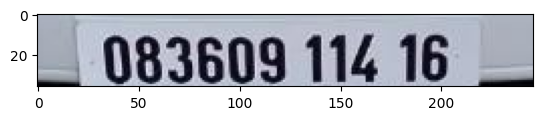

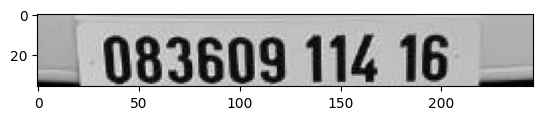

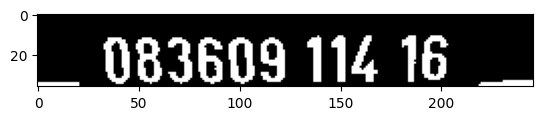

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['030416', '14', '1'] 0.20934193443491045


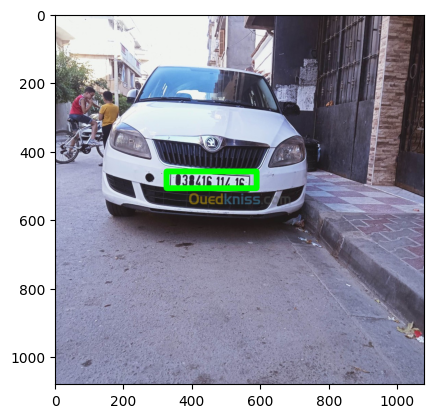

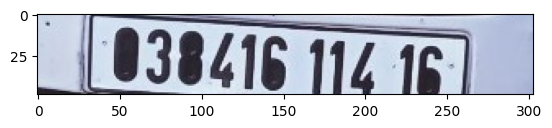

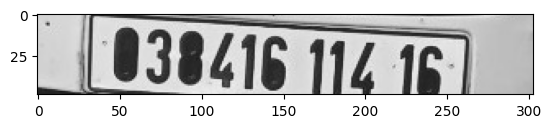

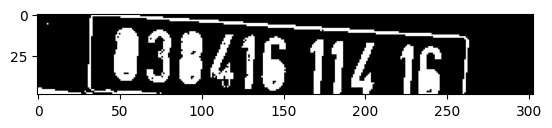

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['00428311520'] 0.9879926607893674


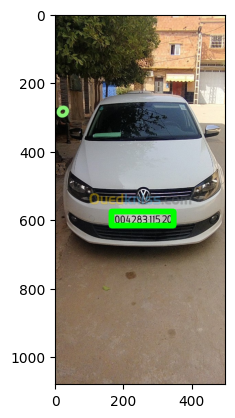

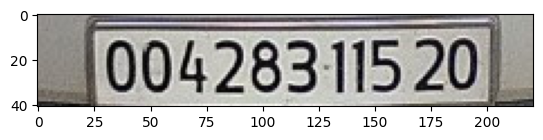

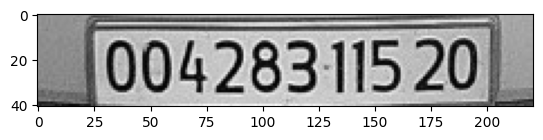

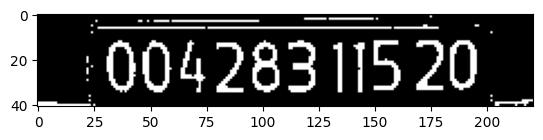

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['022132', '114', '23'] 0.9531135801360291


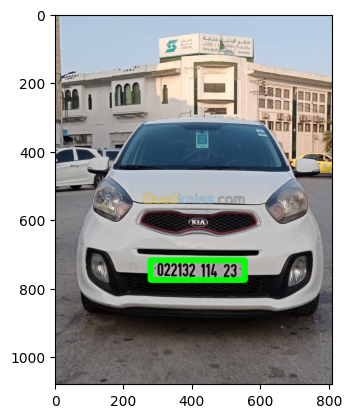

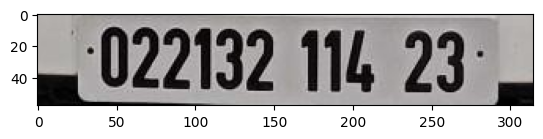

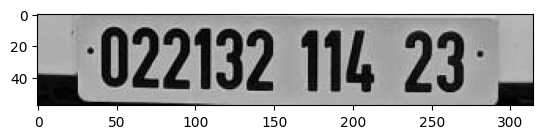

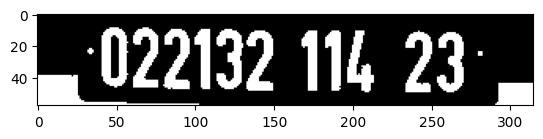

In [11]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

import util
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

# define constants
model_cfg_path = os.path.join('.', 'model', 'cfg', 'darknet-yolov3.cfg')
model_weights_path = os.path.join('.', 'model', 'weights', 'model.weights')
class_names_path = os.path.join('.', 'model', 'class.names')

input_dir = './adnanedata'

for img_name in os.listdir(input_dir):

    img_path = os.path.join(input_dir, img_name)

    # load class names
    with open(class_names_path, 'r') as f:
        class_names = [j[:-1] for j in f.readlines() if len(j) > 2]
        f.close()

    # load model
    net = cv2.dnn.readNetFromDarknet(model_cfg_path, model_weights_path)

    # load image

    img = cv2.imread(img_path)

    H, W, _ = img.shape

    # convert image
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), True)

    # get detections
    net.setInput(blob)

    detections = util.get_outputs(net)

    # bboxes, class_ids, confidences
    bboxes = []
    class_ids = []
    scores = []

    for detection in detections:
        # [x1, x2, x3, x4, x5, x6, ..., x85]
        bbox = detection[:4]

        xc, yc, w, h = bbox
        bbox = [int(xc * W), int(yc * H), int(w * W), int(h * H)]

        bbox_confidence = detection[4]

        class_id = np.argmax(detection[5:])
        score = np.amax(detection[5:])

        bboxes.append(bbox)
        class_ids.append(class_id)
        scores.append(score)

    # apply nms for detect the object is like accoresy in lorning 
    bboxes, class_ids, scores = util.NMS(bboxes, class_ids, scores)


    # plot
    reader = easyocr.Reader(['en'])
    for bbox_, bbox in enumerate(bboxes):
        xc, yc, w, h = bbox

        
        
        

        license_plate = img[int(yc - (h / 2)):int(yc + (h / 2)), int(xc - (w / 2)-20):int(xc + (w / 2)+20), :].copy()

        img = cv2.rectangle(img,
                            (int(xc - (w / 2)), int(yc - (h / 2))),
                            (int(xc + (w / 2)), int(yc + (h / 2))),
                            (0, 255, 0),
                            15)

        license_plate_gray = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
        _, license_plate_thresh= segment_characters(license_plate)
        _, license_plate_thresh = cv2.threshold(license_plate_gray, 64, 255, cv2.THRESH_BINARY_INV)
        
        output = reader.readtext(license_plate)#I apply the read text in the license_plate without segmentation it was working and now it not i dont know why i was getting a better result with segmentation and now it worst

        for out in output:
            text_bbox, text, text_score = out
            text=filterStr(text)
            if text_score > 0.2:
                print(text, text_score)


    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.figure()
    plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))

    plt.figure()
    plt.imshow(cv2.cvtColor(license_plate_gray, cv2.COLOR_BGR2RGB))

    plt.figure()
    plt.imshow(cv2.cvtColor(license_plate_thresh, cv2.COLOR_BGR2RGB))
    plt.show()

